In [1]:
import glob
import os
import os.path as osp
from pprint import pprint
from typing import Tuple, Any

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from notebook_lib import *

/Users/jpgard/opt/miniconda3/envs/tableshift/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
baseline_results_dir = '../domain_shift_results'
tableshift_results_dir = '../ray_train_results'

In [ ]:
# ds_results = read_domain_shift_results(ds_results_dir)

In [ ]:
# TODO(jpgard): read in the rest of the results files, align/combine them, and visualize the results per-dataset.
# Goal is to have one scatter plot per dataset, with model types as markers.

In [6]:
glob.glob('../domain_shift_results/acspubcov/*/*.csv')

[]

In [18]:


dfs = read_tableshift_results(tableshift_results_dir, baseline_results_dir)
all_results = pd.concat(dfs)

[WARNING] missing results file for expt physionet_los47 model ft_transformer matching ../ray_train_results/physionet/*/*.csv; skipping
[WARNING] missing results file for expt physionet_los47 model resnet matching ../ray_train_results/physionet/*/*.csv; skipping


In [19]:
metric = 'validation_accuracy'
df = best_results_by_metric(all_results, metric=metric)
df['delta_acc_test'] = df['ood_test_accuracy'] - df['id_test_accuracy']

In [20]:
tasks = sorted(df.task.unique())
estimators = sorted(df.estimator.unique())
print(f"tasks: {tasks}")
print(f"estimators: {estimators}")

tasks: ['acsfoodstamps', 'acsincome', 'acspubcov', 'acsunemployment', 'anes', 'brfss_blood_pressure', 'brfss_diabetes', 'diabetes', 'heloc', 'mimic_extract_hosp_mort', 'mimic_extract_los_3', 'nhanes_lead', 'physionet_los47']
estimators: ['dann', 'deepcoral', 'ft_transformer', 'group_dro', 'irm', 'lightgbm', 'mixup', 'mlp', 'mmd', 'resnet', 'vrex', 'xgb']


In [ ]:
def plot_confidence_interval(ax, xy, x_int, y_int, color='#2187bb', alpha=0.5, width=0.001):
    """Plot a single (x,y) point with (possibly different) confidence intervals for the x- and y-values."""
    x,y = xy
    xmax = max(x_int)
    xmin = min(x_int)
    ymax = max(y_int)
    ymin = min(y_int)
    ax.plot([x,x], y_int, color=color, alpha=alpha) # vertical bars
    ax.plot(x_int, [y,y], color=color, alpha=alpha)  # horizontal bars
    ax.plot([x-width, x+width], [ymax, ymax], color=color, alpha=alpha)  # top CI "tail"
    ax.plot([x-width, x+width], [ymin, ymin], color=color, alpha=alpha)  # bottom CI "tail"
    ax.plot([xmin, xmin], [y-width, y+width], color=color, alpha=alpha)  # left CI "tail"
    ax.plot([xmax, xmax], [y-width, y+width], color=color, alpha=alpha)  # right CI "tail"
    
    ax.plot(x, y, 's', color=color, alpha=alpha)
    return ax

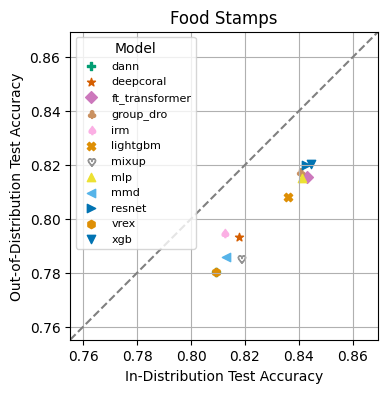

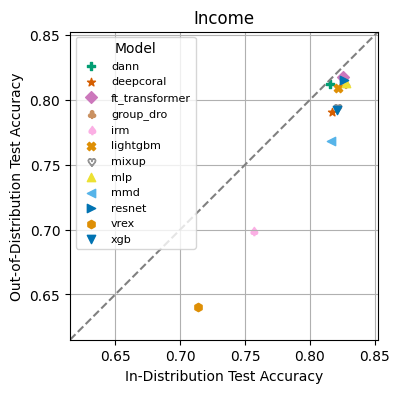

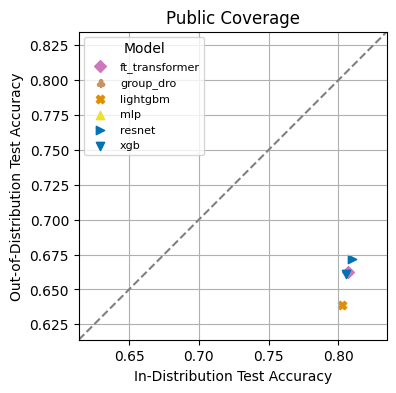

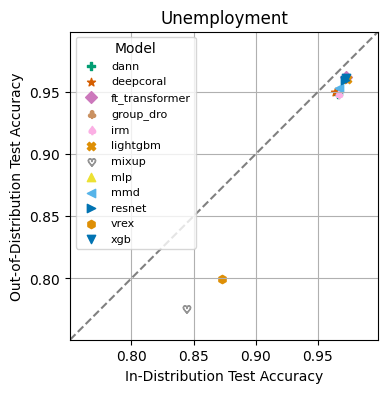

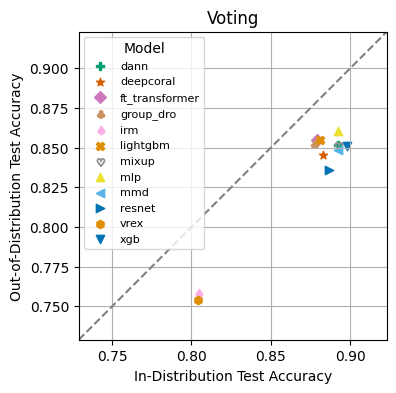

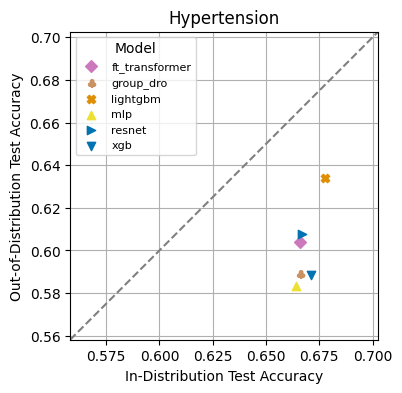

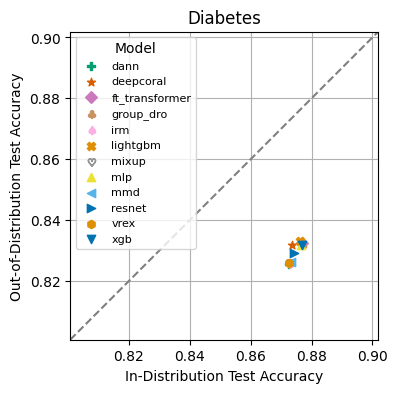

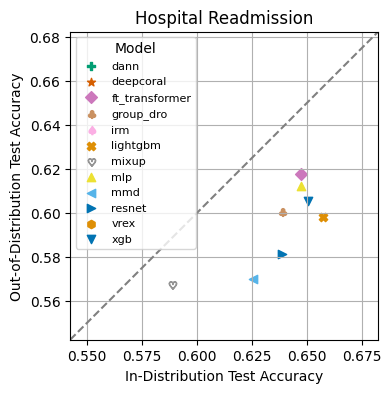

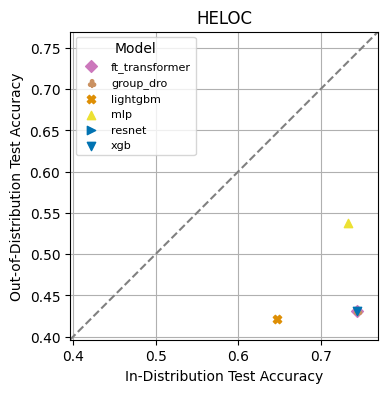

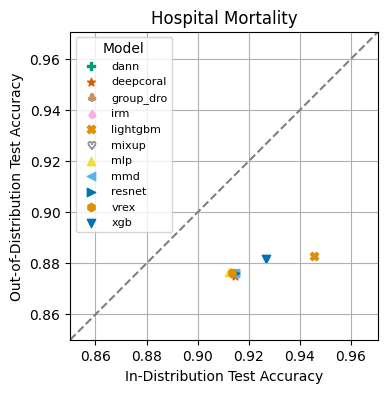

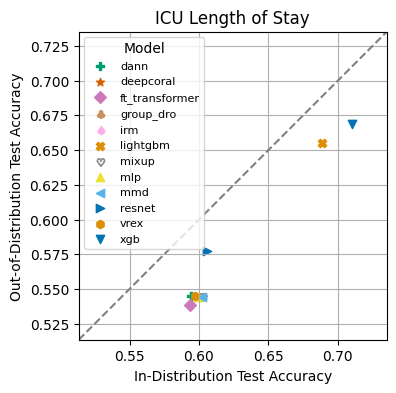

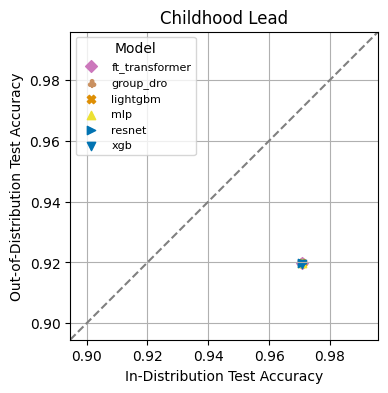

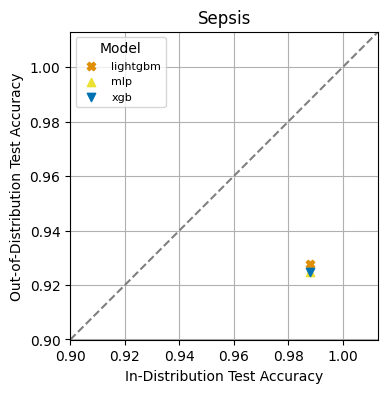

In [31]:
xval = 'id_test_accuracy'
yval = 'ood_test_accuracy'
ood_colname = 'domain_split_ood_values'

axpad = 0.025 # axis margin padding, in data coordinates

estimator_markers = {
    'xgb': 'v',
    'lightgbm': 'X',
    'dann': 'P', 
    'deepcoral': "*", 
    'ft_transformer': "D", 
    'group_dro': '$\clubsuit$', 
    'irm': '$\spadesuit$', 
    'mixup': '$\heartsuit$', 
    'mlp': "^", 
    'mmd': "<", 
    'resnet': ">", 
    'vrex': "h",
}

tasks_to_title = {x.taskname_short: x.title_name for x in EXPERIMENTS_LIST}

_,estimator_colors = values_to_colors(pd.Series(estimator_markers.keys()))

for task in tasks:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
    ax.set_title(tasks_to_title[task])
    task_df = df.query(f"task == '{task}'")

    
    if not len(task_df):
        print(f"no results for task {task}, skipping")
        continue
    for estimator in task_df.estimator.unique():
        df_ = task_df.query(f"estimator == '{estimator}'")
        assert len(df_) == 1  # check exactly one result per task-model pair
        ax.scatter(df_[xval], df_[yval], label=estimator,
               color=estimator_colors[estimator],
               marker=estimator_markers[estimator])
    
    xymin = np.nanmin(task_df[[xval, yval]].values) - axpad
    xymax = np.nanmax(task_df[[xval, yval]].values) + axpad
    
    ax.set(xlim=(xymin, xymax), ylim=(xymin, xymax), 
           xlabel='In-Distribution Test Accuracy',
          ylabel='Out-of-Distribution Test Accuracy')
    ax.set_aspect('equal')
    
    ax.axline((xymin, xymin), slope=1, color="grey", linestyle='--')

    # Label using proxy artists; see https://stackoverflow.com/a/45141109/5843188
    def _proxy_artist(m, c, ls="none"):
        return plt.plot([],[],marker=m, color=c, ls=ls)[0]

#     handles = [_proxy_artist("s", c) for c in domain_cmap.values()]
#     handles += [_proxy_artist(m, "k") for m in estimator_markers.values()]
#     handles.append(_proxy_artist(None, 'grey', '--'))

#     labels = [f'OOD: {k}' for k in domain_cmap.keys()] \
#                 + [f'Model: {e}' for e in estimator_markers.keys()] \
#                 + ['y=x']

#     ax.legend(handles, labels, loc=3, framealpha=1,
#              bbox_to_anchor=(1.1, 0))
    ax.legend(title='Model', fontsize=8)
    ax.grid()

In [11]:
taskname_short = "acsfoodstamps"
f = "acsfoodstampsdomain_split_varname_DIVISIONdomain_split_ood_value_06"
re.search(f"{taskname_short}(.*)", f).group(1)

'domain_split_varname_DIVISIONdomain_split_ood_value_06'